# Libarary

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

from albumentations import *

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image
import random
import os
import cv2
import glob
import PIL.ImageOps

# Data

In [2]:
class cfg:
    data_dir = 'input/data/train'
    img_dir = f'{data_dir}/images'
    df_path = f'{data_dir}/train.csv'

In [3]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3',
             'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

df = pd.read_csv(cfg.df_path)

def changevalue(df, sex, index):
    origin = df.loc[index, 'path']
    if sex == 'female':
        df.loc[index, 'path'] = origin.replace('female','male')
    elif sex == 'male':
        df.loc[index, 'path'] = origin.replace('male','female')
changevalue(df, 'female', 2399)
changevalue(df, 'female', 2400)
changevalue(df, 'female', 2401)
changevalue(df, 'female', 2402)
changevalue(df, 'female', 2403)
changevalue(df, 'male', 1912)
changevalue(df, 'male', 764)

# Image printing

In [4]:
def get_ext(img_dir, img_id):
    """
    학습 데이터셋 이미지 폴더에는 여러 하위폴더로 구성되고, 이 하위폴더들에는 각 사람의 사진들이 들어가있습니다. 하위폴더에 속한 이미지의 확장자를 구하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름

    Returns:
        ext: 이미지의 확장자
    """
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    return ext

# DataGeneration

In [5]:
from albumentations import *
from albumentations.pytorch import ToTensorV2


def get_transforms(need=('train', 'val'), img_size=(512, 384), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):
    """
    train 혹은 validation의 augmentation 함수를 정의합니다. train은 데이터에 많은 변형을 주어야하지만, validation에는 최소한의 전처리만 주어져야합니다.
    
    Args:
        need: 'train', 혹은 'val' 혹은 둘 다에 대한 augmentation 함수를 얻을 건지에 대한 옵션입니다.
        img_size: Augmentation 이후 얻을 이미지 사이즈입니다.
        mean: 이미지를 Normalize할 때 사용될 RGB 평균값입니다.
        std: 이미지를 Normalize할 때 사용될 RGB 표준편차입니다.

    Returns:
        transformations: Augmentation 함수들이 저장된 dictionary 입니다. transformations['train']은 train 데이터에 대한 augmentation 함수가 있습니다.
    """
    transformations = {}
    if 'train' in need:
        transformations['train'] = Compose([     
            Resize(img_size[0], img_size[1]),
            HorizontalFlip(), # 뒤집기
            Crop(x_min=100,y_min=100,x_max=300,y_max=400),
            RandomBrightnessContrast(brightness_limit=(-0.5, 0.5), contrast_limit=0, p=1),
            GaussNoise(p=0.5,var_limit=(100,200)),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0)
        ],p=1.0)
    if 'val' in need:
        transformations['val'] = Compose([
            Resize(img_size[0], img_size[1]),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    return transformations

In [6]:
### 마스크 여부, 성별, 나이를 mapping할 클래스를 생성합니다.
from enum import Enum

class MaskLabels(int, Enum):
    MASK = 0
    INCORRECT = 1
    NORMAL = 2


class GenderLabels(int, Enum):
    MALE = 0
    FEMALE = 1

    @classmethod
    def from_str(cls, value: str) -> int:
        value = value.lower()
        if value == "male":
            return cls.MALE
        elif value == "female":
            return cls.FEMALE
        else:
            raise ValueError(f"Gender value should be either 'male' or 'female', {value}")


class AgeLabels(int, Enum):
    YOUNG = 0
    MIDDLE = 1
    OLD = 2

    @classmethod
    def from_number(cls, value: str) -> int:
        try:
            value = int(value)
        except Exception:
            raise ValueError(f"Age value should be numeric, {value}")

        if value < 30:
            return cls.YOUNG
        elif value < 60:
            return cls.MIDDLE
        else:
            return cls.OLD

In [7]:
class MaskBaseDataset(Dataset):
    num_classes = 3 * 2 * 3

    _file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, img_dir, mean, std, transform=None):
        """
        MaskBaseDataset을 initialize 합니다.

        Args:
            img_dir: 학습 이미지 폴더의 root directory 입니다.
            transform: Augmentation을 하는 함수입니다.
        """
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform = transform

        self.setup()

    def set_transform(self, transform):
        """
        transform 함수를 설정하는 함수입니다.
        """
        self.transform = transform
        
    def setup(self):
        """
        image의 경로와 각 이미지들의 label을 계산하여 저장해두는 함수입니다.
        """
        profiles = os.listdir(self.img_dir)
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.img_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.img_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                mask_label = self._file_names[_file_name]

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)

    def __getitem__(self, index):
        """
        데이터를 불러오는 함수입니다. 
        데이터셋 class에 데이터 정보가 저장되어 있고, index를 통해 해당 위치에 있는 데이터 정보를 불러옵니다.
        
        Args:
            index: 불러올 데이터의 인덱스값입니다.
        """
        # 이미지를 불러옵니다.
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        
        # 레이블을 불러옵니다.
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label * 6 + gender_label * 3 + age_label
        
        # 이미지를 Augmentation 시킵니다.
        image_transform = self.transform(image=np.array(image))['image']
        return image_transform, multi_class_label

    def __len__(self):
        return len(self.image_paths)

In [8]:
# 정의한 Augmentation 함수와 Dataset 클래스 객체를 생성합니다.
mean, std = (0.5, 0.5, 0.5), (0.2, 0.2, 0.2)
transform = get_transforms(mean=mean, std=std)

dataset = MaskBaseDataset(
    img_dir=cfg.img_dir,
    mean=mean,
    std=std
)

dataset.set_transform(transform['val'])
# train dataset과 validation dataset을 8:2 비율로 나눕니다.
n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])

# 각 dataset에 augmentation 함수를 설정합니다.
# train_dataset.dataset.set_transform(transform['train'])
# val_dataset.dataset.set_transform(transform['val'])

In [9]:
# training dataloader은 데이터를 섞어주어야 합니다. (shuffle=True)
train_loader = data.DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=4,
    shuffle=True
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=4,
    shuffle=False
)

In [10]:
images, labels = next(iter(train_loader))
print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

images shape: torch.Size([64, 3, 512, 384])
labels shape: torch.Size([64])


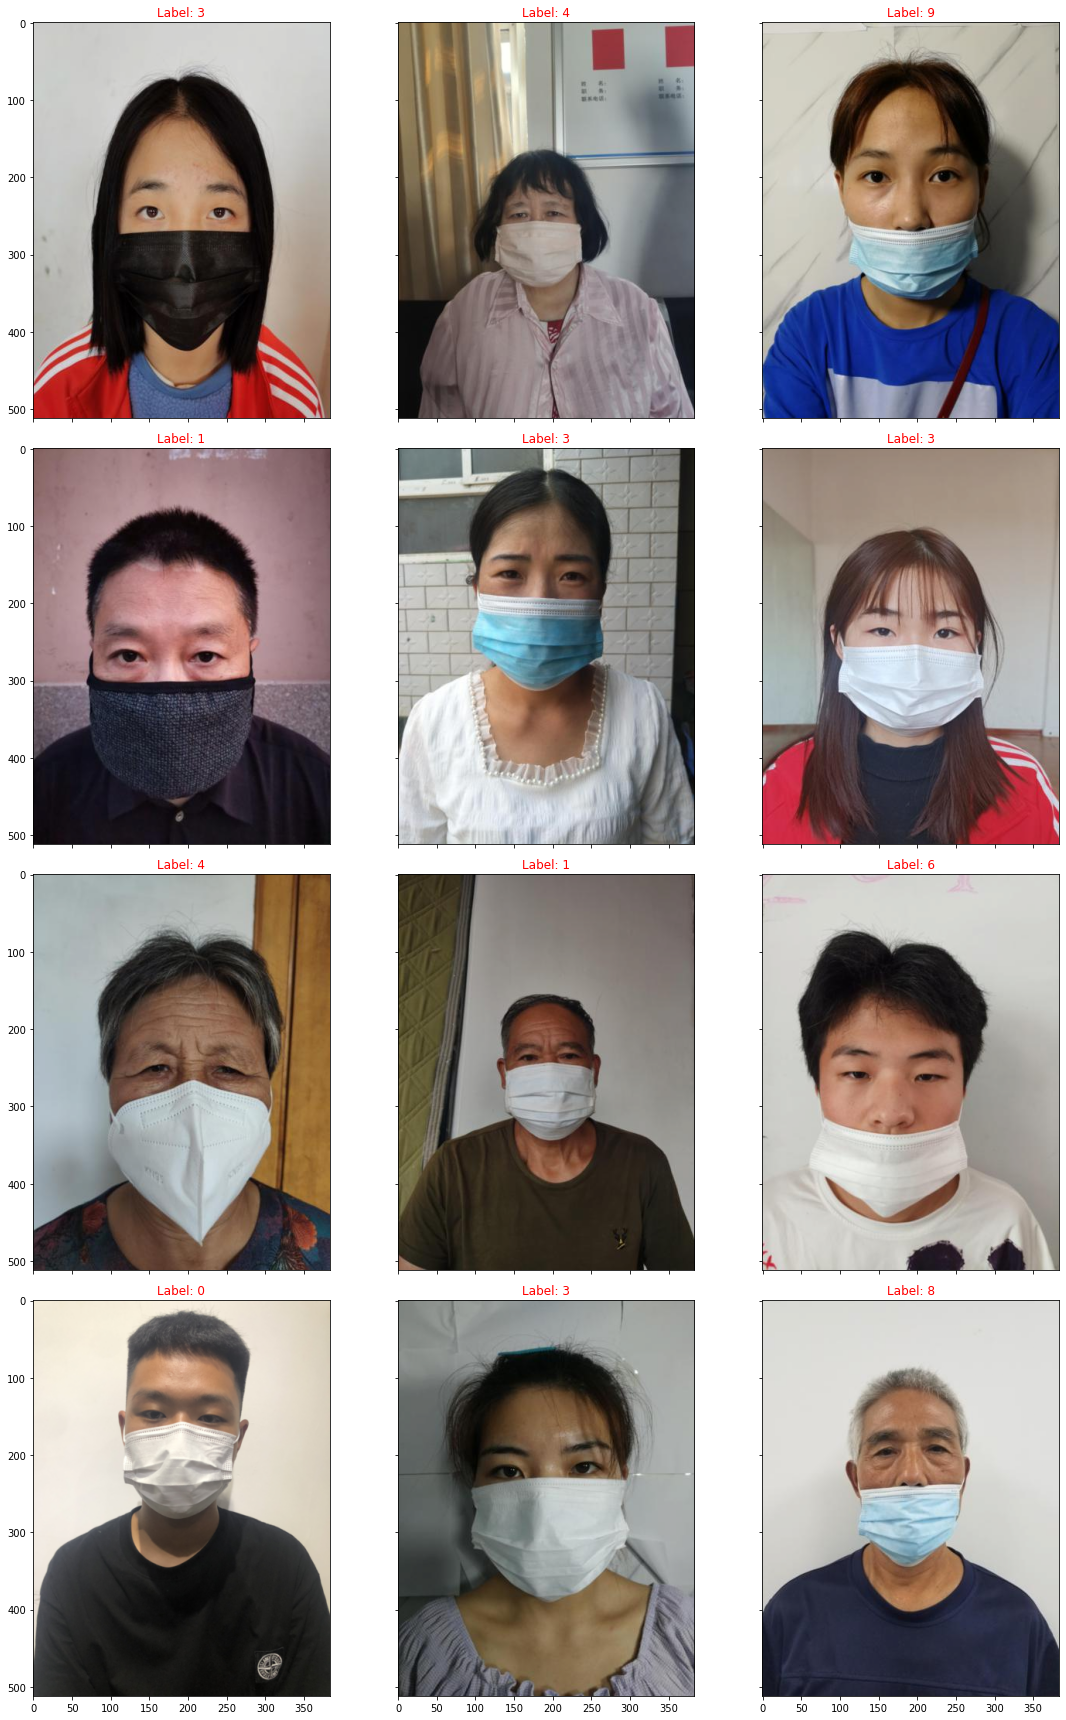

In [11]:
from torchvision import transforms

# Augmentation으로 이미지를 Normalize했기 때문에, 역으로 다시 Normalize 해주어야합니다.
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)

n_rows, n_cols = 4, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(16, 24))
for i in range(n_rows*n_cols):
    axes[i%n_rows][i//(n_cols+1)].imshow(inv_normalize(images[i]).permute(1, 2, 0))
    axes[i%n_rows][i//(n_cols+1)].set_title(f'Label: {labels[i]}', color='r')
plt.tight_layout()

# Model

In [12]:
from torchvision.models import resnext50_32x4d
import torch.nn as nn

# model = resnet34(pretrained=True)
model = resnext50_32x4d(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 18)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [13]:
import torch.nn.init as init

def initialize_weights(model):
    """
    Xavier uniform 분포로 모든 weight 를 초기화합니다.
    더 많은 weight 초기화 방법은 다음 문서에서 참고해주세요. https://pytorch.org/docs/stable/nn.init.html
    """
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

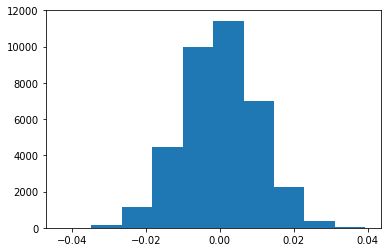

In [14]:
# Classifier 부분만 initialize
initialize_weights(model.fc)

# Weight Initialization 이후 모델 feature 파트의 첫번째 weight 분포
# classifier 부분만 xavier uniform 으로 초기화해서 feature 파트는 uniform 한 분포를 가지지 않는 것을 확인할 수 있습니다.
plt.hist(model.fc.weight.detach().numpy().reshape(-1)) 
plt.show()

In [ ]:
model = resnet34(pretrained=True)

# 모든 weight 를 initialize
initialize_weights(model.fc)

# Weight Initialization 이후 모델 feature 파트의 첫번째 weight 분포
# (xavier) uniform 한 분포로 바뀐 것을 확인할 수 있습니다.
plt.hist(model.fc.weight.detach().numpy().reshape(-1))
plt.show()

## Loss

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, input, target):
        ce_loss = nn.CrossEntropyLoss()(input, target)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [16]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [18]:
model.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [22]:
from sklearn.metrics import f1_score
class get_F1_Score:
    def __init__(self):
        self.reset()
    def reset(self):
        self.y_pred = []
        self.y_true = []
    def update(self,prediction,target):
        self.y_true.extend(target.cpu())
        self.y_pred.extend(prediction.cpu())
    @property
    def get_score(self):
        f1 = f1_score(self.y_true,self.y_pred,average = 'weighted')
        return f1

In [20]:
log_dir='log0414'
epochs=20
batch_size=64
log_interval=20
best_loss = 10 ** 9 # 매우 큰 값으로 초기값 가정
patience_limit = 3 # 몇 번의 epoch까지 지켜볼지를 결정
patience_check = 0 # 현재 몇 epoch 연속으로 loss 개선이 안되는지를 기록

Epoch[0/20](20/237) || training loss 0.6484 || training accuracy 66.48% || lr 0.001
Epoch[0/20](40/237) || training loss 0.1177 || training accuracy 83.67% || lr 0.001
Epoch[0/20](60/237) || training loss 0.08327 || training accuracy 85.16% || lr 0.001
Epoch[0/20](80/237) || training loss 0.05697 || training accuracy 86.33% || lr 0.001
Epoch[0/20](100/237) || training loss 0.04897 || training accuracy 85.86% || lr 0.001
Epoch[0/20](120/237) || training loss 0.04365 || training accuracy 87.42% || lr 0.001
Epoch[0/20](140/237) || training loss 0.04089 || training accuracy 88.05% || lr 0.001
Epoch[0/20](160/237) || training loss 0.02167 || training accuracy 91.02% || lr 0.001
Epoch[0/20](180/237) || training loss 0.02417 || training accuracy 89.14% || lr 0.001
Epoch[0/20](200/237) || training loss 0.0161 || training accuracy 91.48% || lr 0.001
Epoch[0/20](220/237) || training loss 0.01688 || training accuracy 90.94% || lr 0.001
Calculating validation results...
New best model for val accu

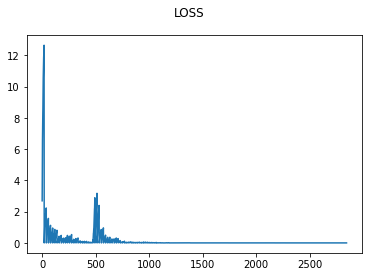

In [23]:
best_loss = 10 ** 9 # 매우 큰 값으로 초기값 가정
patience_limit = 3 # 몇 번의 epoch까지 지켜볼지를 결정
patience_check = 0 # 현재 몇 epoch 연속으로 loss 개선이 안되는지를 기록

os.makedirs(log_dir,exist_ok = True)
with open(os.path.join(log_dir,'adam_focalloss.csv'),'w') as log:
    log.write('iter,train_loss,train_acc')
    best_val_acc = 0
    best_val_loss = np.inf
    losses=[]
    for epoch in range(epochs):
        model.train()
        loss_value = 0
        matches = 0
        valid_f1_score = get_F1_Score()
        for iter,(img,label) in enumerate(train_loader):
            img,label = img.cuda(),label.cuda()
            
            optimizer.zero_grad()
            
            pred_logit = model(img)
            preds = torch.argmax(pred_logit, dim=-1)
            loss = criterion(pred_logit, label)
            
            loss.backward()
            optimizer.step()
            
            loss_value += loss.item()
            
            matches += (preds == label).sum().item()
            if (iter + 1) % log_interval == 0:
                train_loss = loss_value / log_interval
                train_acc = matches / batch_size / log_interval
                current_lr = get_lr(optimizer)
                print(
                    f"Epoch[{epoch}/{epochs}]({iter + 1}/{len(train_loader)}) || "
                    f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
                )
                log.write('%d,%.4f,%.4f\n' %(iter,train_loss, train_acc))
                loss_value = 0
                matches = 0
            losses.append(loss_value)
        with torch.no_grad():
            print("Calculating validation results...")
            model.eval()
            val_loss_items = []
            val_acc_items = []
            for img,label in val_loader:
                img,label = img.cuda(),label.cuda()

                outs = model(img)
                preds = torch.argmax(outs, dim=-1)

                loss_item = criterion(outs, label).item()
                acc_item = (label == preds).sum().item()
                val_loss_items.append(loss_item)
                val_acc_items.append(acc_item)
                valid_f1_score.update(preds, label)
                
            val_loss = np.sum(val_loss_items) / len(val_loader)
            val_acc = np.sum(val_acc_items) / len(val_dataset)
            best_val_loss = min(best_val_loss, val_loss)
            
            if val_loss > best_loss: # loss가 개선되지 않은 경우
                patience_check += 1

                if patience_check >= patience_limit: # early stopping 조건 만족 시 조기 종료
                    break

            else: # loss가 개선된 경우
                best_loss = val_loss
                patience_check = 0
            
            if val_acc > best_val_acc:
                print(f"New best model for val accuracy : {val_acc:4.2%}! saving the best model..")
                best_val_acc = val_acc
            print(
                f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
                f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2} ||"
                f"f1 score: {valid_f1_score.get_score}"
                )
            log.write('%d,%.4f,%.4f\n' %(iter,val_loss,val_acc))
            print()
    plt.plot(losses)
    plt.suptitle('LOSS')
    plt.show()

In [24]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
      for batch_in, batch_out in val_loader:
        batch_in, batch_out = batch_in.to(device), batch_out.to(device)
        outputs = model(batch_in)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_out.size(0)
        correct += (predicted == batch_out).sum().item()
print(100 * correct / total)

98.17460317460318


# Test data

In [25]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [26]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

In [27]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [29]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'focal_earlystop.csv'), index=False)
print('test inference is done!')

KeyboardInterrupt: 

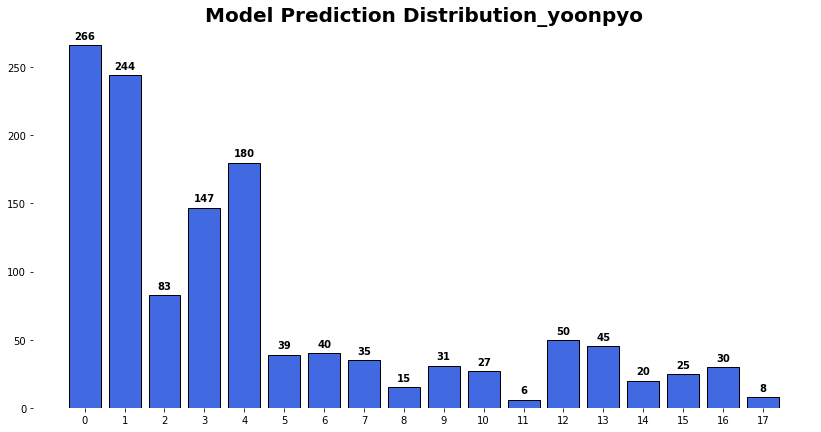

In [30]:
predict_dist = []
for i in range(18):
    predict_dist.append(all_predictions.count(i))
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize = (14,7))
x = range(18)
ax.bar(x,predict_dist,edgecolor = 'black',color = 'royalblue')
ax.set_xticks(x)
ax.set_title('Model Prediction Distribution_yoonpyo',fontweight = 'bold',fontsize = 20)
for s in ['top','right','left','bottom']:
    ax.spines[s].set_visible(False)
for i in range(18):
    ax.text(i,predict_dist[i]+3,str(predict_dist[i]),va = 'bottom',ha = 'center',fontweight = 'semibold')